In [ ]:
import glob
face_images = glob.glob('/content/drive/MyDrive/dataset/archive/**/*.jpg') #returns path of images
print(len(face_images)) 

181


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
face_images = glob.glob('/content/drive/MyDrive/dataset/archive/**/*.jpg') #returns path of images
print(len(face_images)) 

181


In [ ]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

from skimage import data
from skimage.morphology import disk
from skimage.filters import gaussian
from skimage.filters import laplace

In [ ]:
from tqdm import tqdm
from multiprocessing import Pool
progress = tqdm(total= len(face_images), position=0)
def read(path):
  img = image.load_img(path, target_size=(80,80,3))
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img
p = Pool(10)
img_array = p.map(read, face_images)

 11%|█         | 20/181 [00:23<03:21,  1.25s/it]

In [ ]:
with open('img_array.pickle','wb') as f:
  pickle.dump(img_array, f)
print(len(img_array))

181


In [ ]:
all_images = np.array(img_array)
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [ ]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 40):
  filter_image = gaussian(image)
  return filter_image

In [ ]:
train_x_px = []
for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)
train_x_px = np.array(train_x_px)   #Distorted images
# get low resolution images for the validation set
val_x_px = []
for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)
val_x_px = np.array(val_x_px)     #Distorted images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])
# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=100, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

In [ ]:
history = autoencoder.fit(train_x_px,train_x,
            epochs=100,
            validation_data=(val_x_px, val_x),steps_per_epoch=100,
            callbacks=[early_stopper, model_checkpoint],shuffle=True)

Epoch 1/100
100/100 [==============================] - 1s 12ms/step - loss: 2.6078e-04 - accuracy: 0.4707 - val_loss: 3.6959e-04 - val_accuracy: 0.9371
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - loss: 2.4776e-04 - accuracy: 0.4776 - val_loss: 3.9483e-04 - val_accuracy: 0.8188
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 2.8046e-04 - accuracy: 0.4749 - val_loss: 3.7025e-04 - val_accuracy: 0.9388
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 2.5112e-04 - accuracy: 0.4286 - val_loss: 3.3129e-04 - val_accuracy: 0.4444
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 2.3035e-04 - accuracy: 0.4397 - val_loss: 4.2880e-04 - val_accuracy: 0.8306
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 5.8502e-04 - accuracy: 0.4646 - val_loss: 4.0961e-04 - val_accuracy: 0.8590
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 2.7365e-04 -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


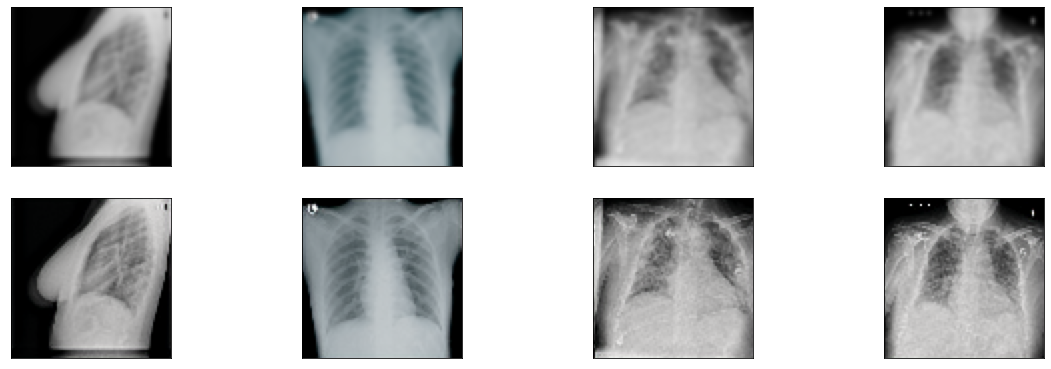

In [ ]:
predictions = autoencoder.predict(val_x_px)
n = 4
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()